In [1]:
import os.path as op
import os
import retro
import pandas as pd
#!pip install gym==0.25.2
import retro
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import Tensor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt


In [2]:
retro.data.add_custom_integration('/scratch/basile/cneuromod.mario3.stimuli/')

In [3]:
def replay_bk2(path, emulator, size=None, reward=None, skip_first_step=True):
    """Replay a bk2 file and return the images as a numpy array
    of shape (n_frames, channels=3, width, height), actions a list of list of bool,
    rewards as a list of floats, done a list of bool, info a list of dict.
    """
    movie = retro.Movie(path)
    emulator.initial_state = movie.get_state()
    emulator.reset()
    images = []
    info = []
    done = []
    rewards = []
    actions = []

    if skip_first_step:
        movie.step()
    while movie.step():
        keys = []
        for p in range(movie.players):
            for i in range(emulator.num_buttons):
                keys.append(movie.get_key(i, p))
        actions.append(keys)
        obs, _rew, _done, _info = emulator.step(keys)
        if size is not None:
            obs = resize(obs, size)
        images.append(obs)
        info.append(_info)
        if reward is None:
            rewards.append(_rew)
        else:
            rewards.apend(_info[reward])
        done.append(_done)
    return np.moveaxis(np.array(images), -1, 1), actions, rewards, done, info

def images_from_array(array):
    if isinstance(array, Tensor):
        array = array.numpy()
    mode = "P" if (array.shape[1] == 1 or len(array.shape) == 3) else "RGB"
    if array.shape[1] == 1:
        array = np.squeeze(array, axis=1)
    if mode == "RGB":
        array = np.moveaxis(array, 1, 3)
    if array.min() < 0 or array.max() < 1:  # if pixel values in [-0.5, 0.5]
        array = 255 * (array + 0.5)

    images = [Image.fromarray(np.uint8(arr), mode) for arr in array]
    return images
    
def save_GIF(array, path, duration=200, optimize=False):
    """Save a GIF from an array of shape (n_frames, channels, width, height),
    also accepts (n_frames, width, height) for grey levels.
    """
    assert path[-4:] == ".gif"
    images = images_from_array(array[0:-1:4])
    images[0].save(
        path, save_all=True, append_images=images[1:], optimize=optimize, loop=0, duration=duration)

def make_replay(bk2_fpath, skip_first_step, save_gif=True, duration=10):
    # Instantiate emulator
    try:
        env = retro.make("SuperMarioBros3-Nes")
        frames, actions, rewards, done, info = replay_bk2(bk2_fpath, env, skip_first_step=skip_first_step)
        repetition_variables = reformat_info(info, actions, env, bk2_fpath)
        if save_gif:
            save_GIF(frames, bk2_fpath.replace(".bk2", ".gif"), duration=duration, optimize=False)
    finally:    
        env.close()
    return repetition_variables

def reformat_info(info, actions, env, bk2_fpath):
    """
    Reformats the info structure for a dictionnary structure containing the relevant info.
    """
    repetition_variables = {}
    repetition_variables["filename"] = bk2_fpath
    repetition_variables["level"] = bk2_fpath.split("/")[-1].split("_")[-2]
    repetition_variables["subject"] = bk2_fpath.split("/")[-1].split("_")[0]
    repetition_variables["session"] = bk2_fpath.split("/")[-1].split("_")[1]
    repetition_variables["repetition"] = bk2_fpath.split("/")[-1].split("_")[-1].split(".")[0]
    repetition_variables["actions"] = env.buttons

    for key in info[0].keys():
        repetition_variables[key] = []
    for button in env.buttons:
        repetition_variables[button] = []
    
    for frame_idx, frame_info in enumerate(info):
        for key in frame_info.keys():
            repetition_variables[key].append(frame_info[key])
        for button_idx, button in enumerate(env.buttons):
            repetition_variables[button].append(actions[frame_idx][button_idx])
    
    return repetition_variables

# Load the data and build a dataframe

In [9]:
# Create a DF with a "done" boolean for each repetition
if not op.isfile("../data/processed/done_df.csv"):
    path_to_data = "../data/sourcedata"

    sub_list = [x for x in os.listdir(path_to_data) if "sub-" in x]
    done_df = pd.DataFrame({"sub":[],
                            "ses":[],
                            "run":[],
                            "repetition":[],
                            "level":[],
                            "done":[],
                            "duration":[]})

    for sub in sorted(sub_list):
        ses_list = [x for x in os.listdir(op.join(path_to_data, sub)) if "ses-" in x]
        for ses in sorted(ses_list):
            eventfiles_list = [x for x in os.listdir(op.join(path_to_data, sub, ses)) if "_events.tsv" in x and "task-mario" in x]
            for eventfile in sorted(eventfiles_list):
                folderpath = op.join(path_to_data, sub, ses)
                event_fname = op.join(folderpath, eventfile)
                events = pd.read_csv(event_fname, sep='\t')
                if not events.trial_type.eq('questionnaire-answer').any():
                    # interrupted run, discard/skip
                    continue
                bk2_idx = 0
                for _, event in events.iterrows():
                    if event["trial_type"] == "gym-retro_game":
                        stim_file = event["stim_file"]
                        bk2_fpath = op.join(path_to_data, sub, ses, stim_file.split("/")[-1])
                        print(bk2_fpath)
                        repetition_variables = make_replay(bk2_fpath, skip_first_step=bk2_idx==0)
                        done = 0
                        print(f"complete_level={repetition_variables['complete_level'][-1]} killed={repetition_variables['killed'][-1]}")
                        if repetition_variables['complete_level'][-1] == 1:
                            if not repetition_variables['killed'][-1] == 1:
                                done = 1
                                print(f"Apparently completed : {bk2_fpath}")
                                print("Complete : {}".format(repetition_variables["complete_level"][-10:]))
                                print("Killed : {}".format(repetition_variables['killed'][-10:]))
                                print("Lives : {}".format(repetition_variables["lives"][-10:]))
                                
                        subj_done_df = done_df[done_df["sub"]==sub]

                        row_df = pd.DataFrame.from_dict({"sub":[sub],
                            "ses":[ses],
                            "run":[eventfile.split("_")[-2]],
                            "repetition":[bk2_fpath.split("/")[-1].split("_")[-1].split(".")[0]],
                            "level":[repetition_variables["level"]],
                            "done":[done],
                            "duration":[len(repetition_variables["time"])/60]})
                        done_df = pd.concat((done_df,row_df))
                        bk2_idx =+ 1

    done_df.to_csv("../data/processed/done_df.csv")
else:
    done_df = pd.read_csv("../data/processed/done_df.csv", sep=",")

In [10]:
bk2_fpath = "../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level1_000.bk2"

# Compute number of levels passed and visualize

In [6]:
# Compute the number of completed levels after each repetition../data/sourcedata/sub-06/ses-017/sub-06_ses-017_20221216-163108_SuperMarioBros3-Nes_1Player.World5.Airship_002.bk2
def compute_completed_over_time(done_df, sub):
    subject_done_df = done_df[done_df["sub"]==sub]
    levels_to_complete = list(np.unique(subject_done_df["level"]))
    n_level_total = len(levels_to_complete)
    repetition_index = []
    n_level_completed_per_index = []
    for idx, rep in enumerate(subject_done_df.iterrows()):
        rep=rep[1]
        repetition_index.append(idx)
        if rep["done"] == 1.0:
            if rep["level"] in levels_to_complete:
                levels_to_complete.remove(rep["level"])
        n_level_completed_per_index.append(n_level_total - len(levels_to_complete))
    return n_level_completed_per_index, repetition_index

for idx, sub in enumerate(sorted(np.unique(done_df["sub"]))):
    n_level_completed_per_index, repetition_index = compute_completed_over_time(done_df, sub)
    #axes.flatten()[idx] = plt.plot(n_level_completed_per_index, repetition_index)

    print(f"{sub} :")
    print(f"Number of bk2s (trials) : {len(n_level_completed_per_index)}")
    print(f"Number of completed levels to date : {n_level_completed_per_index[-1]}")
    print()

sub-01 :
Number of bk2s (trials) : 516
Number of completed levels to date : 36

sub-02 :
Number of bk2s (trials) : 1123
Number of completed levels to date : 24

sub-03 :
Number of bk2s (trials) : 847
Number of completed levels to date : 16

sub-05 :
Number of bk2s (trials) : 327
Number of completed levels to date : 11

sub-06 :
Number of bk2s (trials) : 482
Number of completed levels to date : 55



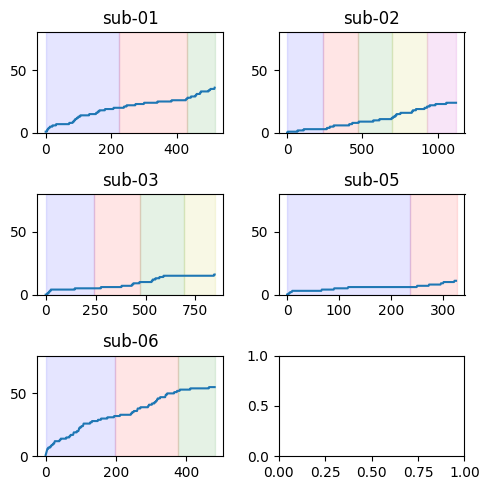

In [8]:


fig, axes = plt.subplots(3,2, figsize=(5,5))
for idx, sub in enumerate(sorted(np.unique(done_df["sub"]))):
    ax = axes.flatten()[idx]
    n_level_completed_per_index, repetition_index = compute_completed_over_time(done_df, sub)    
    ax.plot(repetition_index, n_level_completed_per_index)
    ax.set_ylim([0, 80])
    ax.set_title(sub)

    # Add cycles
    cycles = np.asarray((done_df[done_df['sub']==sub].level.str.replace(r'1Player.World([0-9]+).[A-Za-z]+([0-9]*)',r'\1.00000\2',regex=True).astype(float).diff()!=0).cumsum()//80)
    cycles_idx, cycles_length = np.unique(cycles, return_counts=True)
    next_seed = 0
    colors = ["b", "r", "g", "y", "m"]
    for cycle_idx in cycles_idx:
        rectangle = Rectangle((next_seed, 0), cycles_length[cycle_idx], 80, alpha = 0.1, color=colors[cycle_idx])
        ax.add_patch(rectangle)
        next_seed = next_seed + cycles_length[cycle_idx]
    
    
        
plt.tight_layout()

# Make a videoclip of a repetition in order to confirm if its passed or not

In [26]:
filepath = "../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-115003_SuperMarioBros3-Nes_1Player.World1.Level5_000.bk2"

duration = 10

split_filepath = filepath.split("/")
split_filename = split_filepath[-1].split("_")
level = split_filename[-2]

# Instantiate emulator

env = retro.make("SuperMarioBros3-Nes", state=level)
frames, actions, rewards, done, info = replay_bk2(filepath, env, skip_first_step=True)
env.close()

save_GIF(frames, "test.gif", duration=duration, optimize=False)



In [23]:
path_to_data = "../data/sourcedata"
sub_list = [x for x in os.listdir(path_to_data) if "sub-" in x]
for sub in sorted(sub_list):
    ses_list = [x for x in os.listdir(op.join(path_to_data, sub)) if "ses-" in x]
    for ses in sorted(ses_list):
        eventfiles_list = [x for x in os.listdir(op.join(path_to_data, sub, ses)) if "_events.tsv" in x and "task-mario" in x]
        for eventfile in sorted(eventfiles_list):
            folderpath = op.join(path_to_data, sub, ses)
            event_fname = op.join(folderpath, eventfile)
            events = pd.read_csv(event_fname, sep='\t')
            if not events.trial_type.eq('questionnaire-answer').any():
                # interrupted run, discard/skip
                continue
            bk2_idx = 0
            for _, event in events.iterrows():
                if event["trial_type"] == "gym-retro_game":
                    stim_file = event["stim_file"]
                    bk2_fpath = op.join(path_to_data, sub, ses, stim_file.split("/")[-1])
                    print(bk2_fpath)
                    make_replay(bk2_fpath, skip_first_step=bk2_idx==0, duration=17)
                    bk2_idx =+ 1
                    

../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level1_000.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level2_000.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level2_001.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level2_002.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level3_000.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level4_000.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Level4_001.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBros3-Nes_1Player.World1.Fortress_000.bk2
../data/sourcedata/sub-01/ses-001/sub-01_ses-001_20221007-113823_SuperMarioBro

KeyboardInterrupt: 

In [39]:
env.buttons

['B', None, 'SELECT', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'A']

In [32]:
    env = retro.make("SuperMarioBros3-Nes")
    frames, actions, rewards, done, info = replay_bk2(filepath, env, skip_first_step=False)
    env.close()

In [46]:
bk2_fpath.split("/")[-1].split("_")[-1].split(".")[0]

'001'

In [47]:
def reformat_info(info, actions, env, bk2_fpath):
    """
    Reformats the info structure for a dictionnary structure containing the relevant info.
    """
    repetition_variables = {}
    repetition_variables["filename"] = bk2_fpath
    repetition_variables["level"] = bk2_fpath.split("/")[-1].split("_")[-2]
    repetition_variables["subject"] = bk2_fpath.split("/")[-1].split("_")[0]
    repetition_variables["session"] = bk2_fpath.split("/")[-1].split("_")[1]
    repetition_variables["repetition"] = bk2_fpath.split("/")[-1].split("_")[-1].split(".")[0]
    repetition_variables["actions"] = env.buttons

    for key in info[0].keys():
        repetition_variables[key] = []
    for button in env.buttons:
        repetition_variables[button] = []
    
    for frame_idx, frame_info in enumerate(info):
        for key in frame_info.keys():
            repetition_variables[key].append(frame_info[key])
        for button_idx, button in enumerate(env.buttons):
            repetition_variables[button].append(actions[frame_idx][button_idx])
    
    return repetition_variables

In [48]:
repetition_variables = reformat_info(info, actions, env, bk2_fpath)

In [49]:
repetition_variables

{'filename': '../data/sourcedata/sub-01/ses-013/sub-01_ses-013_20230113-113337_SuperMarioBros3-Nes_1Player.World4.Airship_001.bk2',
 'level': '1Player.World4.Airship',
 'subject': 'sub-01',
 'session': 'ses-013',
 'repetition': '001',
 'actions': ['B', None, 'SELECT', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'A'],
 'timer_1': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,